In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.special import expit  # For logistic function
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Tuple, Union, Any

In [2]:
path = '/media/ak/DataOnly1/NIPSProjectData'

In [9]:
files = [f for f in os.listdir(path) if '.csv' in f]
files

['diabetes_012_health_indicators_BRFSS2015.csv.zip',
 'diabetes_012_health_indicators_BRFSS2015.csv']

In [12]:
filePath = os.path.join(path, files[1])
df =pd.read_csv(filePath)

In [15]:
df.columns.values

array(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
       'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
       'Education', 'Income'], dtype=object)

In [ ]:
# OSRCT (Observational Study Randomized Controlled Trial) Analysis Functions

def create_osrct_dataset(df, outcome, treatment, covariates, biasing_covariates):
    """
    Create a dataset that simulates an OSRCT by selecting observations 
    with specific covariate patterns.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataset
    outcome : str
        The name of the outcome variable
    treatment : str
        The name of the treatment variable
    covariates : list
        List of covariate names
    biasing_covariates : list
        List of covariates that are used to bias the selection
        
    Returns:
    --------
    osrct_df : pandas DataFrame
        The OSRCT dataset
    true_effect : float
        The true treatment effect in the original dataset
    complement_df : pandas DataFrame
        The complementary dataset (observations not in the OSRCT)
    """
    import numpy as np
    
    # Calculate true effect in the original data
    treated = df[df[treatment] == 1]
    control = df[df[treatment] == 0]
    true_effect = treated[outcome].mean() - control[outcome].mean()
    
    # Create a selection score based on biasing covariates
    selection_score = np.zeros(len(df))
    for cov in biasing_covariates:
        # Normalize the covariate to [0, 1]
        norm_cov = (df[cov] - df[cov].min()) / (df[cov].max() - df[cov].min())
        selection_score += norm_cov
    
    # Select top 30% of scores to create OSRCT
    threshold = np.percentile(selection_score, 70)
    osrct_mask = selection_score >= threshold
    osrct_df = df[osrct_mask].copy()
    complement_df = df[~osrct_mask].copy()
    
    return osrct_df, true_effect, complement_df

def analyze_osrct_bias(df, osrct_df, treatment, biasing_covariates):
    """
    Analyze the bias in the OSRCT dataset compared to the original dataset.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataset
    osrct_df : pandas DataFrame
        The OSRCT dataset
    treatment : str
        The name of the treatment variable
    biasing_covariates : list
        List of covariates that were used to bias the selection
        
    Returns:
    --------
    bias_df : pandas DataFrame
        DataFrame showing the bias in each covariate
    """
    import pandas as pd
    
    bias_data = []
    
    # Analyze overall distributions
    for cov in biasing_covariates:
        original_mean = df[cov].mean()
        osrct_mean = osrct_df[cov].mean()
        bias_pct = ((osrct_mean - original_mean) / original_mean) * 100
        
        bias_data.append({
            'Covariate': cov,
            'Group': 'Overall',
            'Original_Mean': original_mean,
            'OSRCT_Mean': osrct_mean,
            'Bias_Percent': bias_pct
        })
    
    # Analyze treatment group distributions
    for cov in biasing_covariates:
        # Treatment group
        orig_treated = df[df[treatment] == 1]
        osrct_treated = osrct_df[osrct_df[treatment] == 1]
        
        orig_treated_mean = orig_treated[cov].mean()
        osrct_treated_mean = osrct_treated[cov].mean()
        bias_pct = ((osrct_treated_mean - orig_treated_mean) / orig_treated_mean) * 100
        
        bias_data.append({
            'Covariate': cov,
            'Group': 'Treated',
            'Original_Mean': orig_treated_mean,
            'OSRCT_Mean': osrct_treated_mean,
            'Bias_Percent': bias_pct
        })
        
        # Control group
        orig_control = df[df[treatment] == 0]
        osrct_control = osrct_df[osrct_df[treatment] == 0]
        
        orig_control_mean = orig_control[cov].mean()
        osrct_control_mean = osrct_control[cov].mean()
        bias_pct = ((osrct_control_mean - orig_control_mean) / orig_control_mean) * 100
        
        bias_data.append({
            'Covariate': cov,
            'Group': 'Control',
            'Original_Mean': orig_control_mean,
            'OSRCT_Mean': osrct_control_mean,
            'Bias_Percent': bias_pct
        })
    
    bias_df = pd.DataFrame(bias_data)
    return bias_df

def estimate_treatment_effects(osrct_df, outcome, treatment, covariates, methods=None, true_effect=None):
    """
    Estimate treatment effects using various methods.
    
    Parameters:
    -----------
    osrct_df : pandas DataFrame
        The OSRCT dataset
    outcome : str
        The name of the outcome variable
    treatment : str
        The name of the treatment variable
    covariates : list
        List of covariate names
    methods : list, optional
        List of methods to use. Options: 'naive', 'regression', 'ipw', 'matching'
    true_effect : float, optional
        The true treatment effect for comparison
        
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame with the results of each method
    """
    import pandas as pd
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    
    if methods is None:
        methods = ['naive', 'regression', 'ipw', 'matching']
    
    results = {'Method': [], 'Effect_Estimate': [], 'SE': [], 'CI_Lower': [], 'CI_Upper': []}
    
    # Add true effect if provided
    if true_effect is not None:
        results['Method'].append('True_Effect')
        results['Effect_Estimate'].append(true_effect)
        results['SE'].append(np.nan)
        results['CI_Lower'].append(np.nan)
        results['CI_Upper'].append(np.nan)
    
    # 1. Naive difference in means
    if 'naive' in methods:
        treated = osrct_df[osrct_df[treatment] == 1]
        control = osrct_df[osrct_df[treatment] == 0]
        
        effect = treated[outcome].mean() - control[outcome].mean()
        
        # Calculate standard error and CI
        n1 = len(treated)
        n0 = len(control)
        var1 = treated[outcome].var()
        var0 = control[outcome].var()
        
        se = np.sqrt(var1/n1 + var0/n0)
        ci_lower = effect - 1.96 * se
        ci_upper = effect + 1.96 * se
        
        results['Method'].append('Naive')
        results['Effect_Estimate'].append(effect)
        results['SE'].append(se)
        results['CI_Lower'].append(ci_lower)
        results['CI_Upper'].append(ci_upper)
    
    # 2. Regression adjustment
    if 'regression' in methods:
        X = osrct_df[covariates].copy()
        X[treatment] = osrct_df[treatment]
        y = osrct_df[outcome]
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Effect is the coefficient of treatment
        effect = model.coef_[list(X.columns).index(treatment)]
        
        # Calculate standard error (simplified)
        y_pred = model.predict(X)
        n = len(y)
        p = X.shape[1]
        mse = np.sum((y - y_pred) ** 2) / (n - p - 1)
        
        # Approximate SE for the treatment coefficient
        X_treatment = X.copy()
        X_control = X.copy()
        X_treatment[treatment] = 1
        X_control[treatment] = 0
        
        pred_diff = np.mean(model.predict(X_treatment) - model.predict(X_control))
        se = np.sqrt(mse * (1/n))  # Simplified SE
        
        ci_lower = effect - 1.96 * se
        ci_upper = effect + 1.96 * se
        
        results['Method'].append('Regression')
        results['Effect_Estimate'].append(effect)
        results['SE'].append(se)
        results['CI_Lower'].append(ci_lower)
        results['CI_Upper'].append(ci_upper)
    
    # 3. Inverse Probability Weighting (IPW)
    if 'ipw' in methods:
        from sklearn.linear_model import LogisticRegression
        
        # Propensity score model
        ps_model = LogisticRegression()
        ps_model.fit(osrct_df[covariates], osrct_df[treatment])
        
        # Get propensity scores
        ps = ps_model.predict_proba(osrct_df[covariates])[:, 1]
        
        # Calculate weights
        osrct_df['ps'] = ps
        osrct_df['ipw'] = np.where(osrct_df[treatment] == 1, 
                                  1/osrct_df['ps'], 
                                  1/(1-osrct_df['ps']))
        
        # Trim extreme weights
        q99 = np.percentile(osrct_df['ipw'], 99)
        osrct_df['ipw'] = np.minimum(osrct_df['ipw'], q99)
        
        # Calculate weighted means
        treated = osrct_df[osrct_df[treatment] == 1]
        control = osrct_df[osrct_df[treatment] == 0]
        
        weighted_treated_mean = np.sum(treated[outcome] * treated['ipw']) / np.sum(treated['ipw'])
        weighted_control_mean = np.sum(control[outcome] * control['ipw']) / np.sum(control['ipw'])
        
        effect = weighted_treated_mean - weighted_control_mean
        
        # Approximate SE (bootstrap would be better in practice)
        se = np.sqrt(
            np.var(treated[outcome] * treated['ipw']) / len(treated) + 
            np.var(control[outcome] * control['ipw']) / len(control)
        )
        
        ci_lower = effect - 1.96 * se
        ci_upper = effect + 1.96 * se
        
        results['Method'].append('IPW')
        results['Effect_Estimate'].append(effect)
        results['SE'].append(se)
        results['CI_Lower'].append(ci_lower)
        results['CI_Upper'].append(ci_upper)
    
    # 4. Matching
    if 'matching' in methods:
        from sklearn.neighbors import NearestNeighbors
        
        # Standardize covariates
        scaler = StandardScaler()
        X = scaler.fit_transform(osrct_df[covariates])
        
        # Split into treated and control
        treated_idx = osrct_df[treatment] == 1
        control_idx = osrct_df[treatment] == 0
        
        X_treated = X[treated_idx]
        X_control = X[control_idx]
        
        y_treated = osrct_df.loc[treated_idx, outcome].values
        y_control = osrct_df.loc[control_idx, outcome].values
        
        # Find matches
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(X_control)
        distances, indices = nn.kneighbors(X_treated)
        
        # Calculate effect
        matched_control = y_control[indices.flatten()]
        effect = np.mean(y_treated - matched_control)
        
        # Calculate standard error
        diffs = y_treated - matched_control
        se = np.std(diffs) / np.sqrt(len(diffs))
        
        ci_lower = effect - 1.96 * se
        ci_upper = effect + 1.96 * se
        
        results['Method'].append('Matching')
        results['Effect_Estimate'].append(effect)
        results['SE'].append(se)
        results['CI_Lower'].append(ci_lower)
        results['CI_Upper'].append(ci_upper)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    return results_df



Dataset loaded successfully!
Original dataset: 253680 observations, 42.9% treated
OSRCT dataset: 164151 observations (64.7% of original), 37.0% treated
Complementary sample: 89529 observations (35.3% of original)


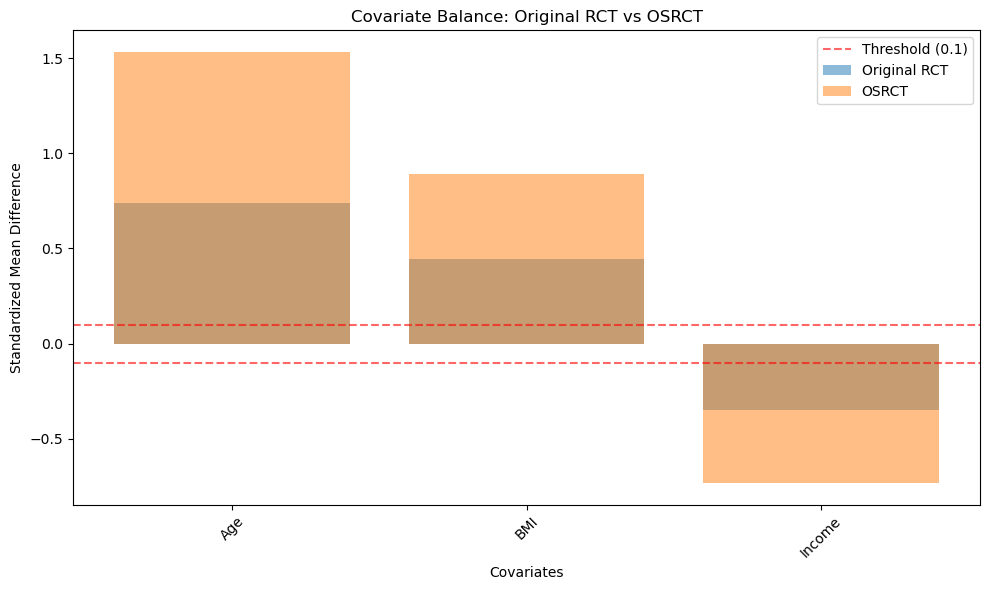

Error computing IPW estimate: local variable 'np' referenced before assignment

Treatment effect estimates:
                      method  estimate      bias
0         Naive (unadjusted)  0.533902  0.150785
1      Regression adjustment  0.220573 -0.162544
2  Propensity score matching  0.220639 -0.162478


In [24]:
# Example usage
if __name__ == "__main__":

    
    # Load a sample dataset
    # Replace with your actual file path
    try:
        # The error was here: df = filePath (filePath is a string, not a DataFrame)
        # Instead, we need to read the file using pandas
        file_path = filePath   # Replace with actual path
        df = pd.read_csv(file_path)  # This line fixes the error
        print("Dataset loaded successfully!")
        
        # Define variables
        outcome = 'Diabetes_012'
        treatment = 'HighBP'
        covariates = [col for col in df.columns if col not in [outcome, treatment]]
        biasing_covariates = ['Age', 'BMI', 'Income']
        
        # Create OSRCT dataset
        osrct_df, true_effect, complement_df = create_osrct_dataset(
            df, outcome, treatment, covariates, biasing_covariates)
        
        # Analyze bias
        bias_df = analyze_osrct_bias(df, osrct_df, treatment, biasing_covariates)
        
        # Estimate treatment effects
        results = estimate_treatment_effects(
            osrct_df, outcome, treatment, covariates, 
            methods=['naive', 'regression', 'ipw', 'matching'],
            true_effect=true_effect)
        
        print("\nTreatment effect estimates:")
        print(results)
        
    except FileNotFoundError:
        print("Sample file not found. Replace with your actual file path.")

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_diabetes_data(file_path):
    """
    Load the diabetes dataset and prepare it for OSRCT analysis.
    
    Parameters:
    -----------
    file_path : str
        Path to the diabetes dataset CSV file
        
    Returns:
    --------
    df : pandas DataFrame
        The loaded dataset
    """
    try:
        # Load the dataset
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
        
        # Check if key columns exist
        expected_columns = ['Diabetes_012', 'HighBP', 'BMI', 'Age', 'Income']
        missing_columns = [col for col in expected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"Warning: The following expected columns are missing: {missing_columns}")
        
        # Display column information
        print("\nColumns in the dataset:")
        print(df.columns.tolist())
        
        # Display basic statistics
        print("\nBasic statistics for key variables:")
        if 'Diabetes_012' in df.columns:
            print(f"Diabetes prevalence: {df['Diabetes_012'].value_counts(normalize=True)}")
        
        if 'HighBP' in df.columns:
            print(f"High blood pressure prevalence: {df['HighBP'].value_counts(normalize=True)}")
        
        return df
    
    except Exception as e:
        print(f"Error loading the dataset: {e}")
        return None

def prepare_osrct_data(df, outcome='Diabetes_012', treatment='HighBP', 
                       biasing_covariates=['Age', 'BMI', 'Income'], random_seed=42):
    """
    Prepare a dataset for OSRCT analysis by creating biased training and complementary test sets.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataset
    outcome : str
        Name of the outcome variable
    treatment : str
        Name of the treatment variable
    biasing_covariates : list
        List of covariates to use for biasing the sample
    random_seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    train_df : pandas DataFrame
        The biased training dataset (OSRCT dataset)
    test_df : pandas DataFrame
        The complementary test dataset
    true_effect : float
        The true treatment effect from the original dataset
    covariates : list
        List of all covariates (excluding outcome and treatment)
    """
    # Validate inputs
    for col in [outcome, treatment] + biasing_covariates:
        if col not in df.columns:
            raise ValueError(f"Column {col} not found in the dataset")
    
    # Calculate true effect in the original data
    treated = df[df[treatment] == 1]
    control = df[df[treatment] == 0]
    true_effect = treated[outcome].mean() - control[outcome].mean()
    print(f"\nTrue treatment effect: {true_effect:.4f}")
    
    # Get all covariates (excluding outcome and treatment)
    covariates = [col for col in df.columns if col not in [outcome, treatment]]
    
    # Split into training and test sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_seed)
    
    # Create a selection score based on biasing covariates for OSRCT
    selection_score = np.zeros(len(train_df))
    for cov in biasing_covariates:
        # Handle categorical variables
        if train_df[cov].dtype == 'object':
            # One-hot encode categorical variables
            dummies = pd.get_dummies(train_df[cov], prefix=cov)
            # Use the first dummy variable for biasing
            norm_cov = dummies.iloc[:, 0]
        else:
            # Normalize numeric covariates to [0, 1]
            norm_cov = (train_df[cov] - train_df[cov].min()) / (train_df[cov].max() - train_df[cov].min() + 1e-10)
        
        selection_score += norm_cov
    
    # Select top 50% of scores to create OSRCT
    threshold = np.percentile(selection_score, 50)
    osrct_mask = selection_score >= threshold
    
    # Create biased dataset and complementary dataset
    osrct_df = train_df[osrct_mask].copy()
    complement_df = train_df[~osrct_mask].copy()
    
    print(f"\nOSRCT dataset created with {osrct_df.shape[0]} observations")
    print(f"Complementary dataset created with {complement_df.shape[0]} observations")
    
    # Check the treatment distribution in biased vs original data
    orig_treatment_rate = train_df[treatment].mean()
    biased_treatment_rate = osrct_df[treatment].mean()
    
    print(f"\nTreatment rate in original data: {orig_treatment_rate:.4f}")
    print(f"Treatment rate in OSRCT data: {biased_treatment_rate:.4f}")
    print(f"Bias introduced: {(biased_treatment_rate - orig_treatment_rate) / orig_treatment_rate:.2%}")
    
    return osrct_df, complement_df, true_effect, covariates


# Example usage
if __name__ == "__main__":

    
    # Load the data
    df = load_diabetes_data(filePath)
    
    if df is not None:
        # Define variables
        outcome = 'Diabetes_012'
        treatment = 'HighBP'
        biasing_covariates = ['Age', 'BMI', 'Income']
        
        # Prepare OSRCT dataset
        osrct_df, complement_df, true_effect, covariates = prepare_osrct_data(
            df, outcome, treatment, biasing_covariates)

Dataset loaded successfully with 253680 rows and 22 columns.

Columns in the dataset:
['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Basic statistics for key variables:
Diabetes prevalence: Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64
High blood pressure prevalence: HighBP
0.0    0.570999
1.0    0.429001
Name: proportion, dtype: float64

True treatment effect: 0.3831

OSRCT dataset created with 101619 observations
Complementary dataset created with 101325 observations

Treatment rate in original data: 0.4282
Treatment rate in OSRCT data: 0.4861
Bias introduced: 13.52%


In [27]:
# OSRCT (Observational Study Randomized Controlled Trial) Analysis Functions

def create_osrct_dataset(df, outcome, treatment, covariates, biasing_covariates):
    """
    Create a dataset that simulates an OSRCT by selecting observations 
    with specific covariate patterns.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataset
    outcome : str
        The name of the outcome variable
    treatment : str
        The name of the treatment variable
    covariates : list
        List of covariate names
    biasing_covariates : list
        List of covariates that are used to bias the selection
        
    Returns:
    --------
    osrct_df : pandas DataFrame
        The OSRCT dataset
    true_effect : float
        The true treatment effect in the original dataset
    complement_df : pandas DataFrame
        The complementary dataset (observations not in the OSRCT)
    """
    import numpy as np
    
    # Calculate true effect in the original data
    treated = df[df[treatment] == 1]
    control = df[df[treatment] == 0]
    true_effect = treated[outcome].mean() - control[outcome].mean()
    
    # Create a selection score based on biasing covariates
    selection_score = np.zeros(len(df))
    for cov in biasing_covariates:
        # Normalize the covariate to [0, 1]
        norm_cov = (df[cov] - df[cov].min()) / (df[cov].max() - df[cov].min())
        selection_score += norm_cov
    
    # Select top 30% of scores to create OSRCT
    threshold = np.percentile(selection_score, 70)
    osrct_mask = selection_score >= threshold
    osrct_df = df[osrct_mask].copy()
    complement_df = df[~osrct_mask].copy()
    
    return osrct_df, true_effect, complement_df

def analyze_osrct_bias(df, osrct_df, treatment, biasing_covariates):
    """
    Analyze the bias in the OSRCT dataset compared to the original dataset.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataset
    osrct_df : pandas DataFrame
        The OSRCT dataset
    treatment : str
        The name of the treatment variable
    biasing_covariates : list
        List of covariates that were used to bias the selection
        
    Returns:
    --------
    bias_df : pandas DataFrame
        DataFrame showing the bias in each covariate
    """
    import pandas as pd
    
    bias_data = []
    
    # Analyze overall distributions
    for cov in biasing_covariates:
        original_mean = df[cov].mean()
        osrct_mean = osrct_df[cov].mean()
        bias_pct = ((osrct_mean - original_mean) / original_mean) * 100
        
        bias_data.append({
            'Covariate': cov,
            'Group': 'Overall',
            'Original_Mean': original_mean,
            'OSRCT_Mean': osrct_mean,
            'Bias_Percent': bias_pct
        })
    
    # Analyze treatment group distributions
    for cov in biasing_covariates:
        # Treatment group
        orig_treated = df[df[treatment] == 1]
        osrct_treated = osrct_df[osrct_df[treatment] == 1]
        
        orig_treated_mean = orig_treated[cov].mean()
        osrct_treated_mean = osrct_treated[cov].mean()
        bias_pct = ((osrct_treated_mean - orig_treated_mean) / orig_treated_mean) * 100
        
        bias_data.append({
            'Covariate': cov,
            'Group': 'Treated',
            'Original_Mean': orig_treated_mean,
            'OSRCT_Mean': osrct_treated_mean,
            'Bias_Percent': bias_pct
        })
        
        # Control group
        orig_control = df[df[treatment] == 0]
        osrct_control = osrct_df[osrct_df[treatment] == 0]
        
        orig_control_mean = orig_control[cov].mean()
        osrct_control_mean = osrct_control[cov].mean()
        bias_pct = ((osrct_control_mean - orig_control_mean) / orig_control_mean) * 100
        
        bias_data.append({
            'Covariate': cov,
            'Group': 'Control',
            'Original_Mean': orig_control_mean,
            'OSRCT_Mean': osrct_control_mean,
            'Bias_Percent': bias_pct
        })
    
    bias_df = pd.DataFrame(bias_data)
    return bias_df

def estimate_treatment_effects(osrct_df, outcome, treatment, covariates, methods=None, true_effect=None):
    """
    Estimate treatment effects using various methods.
    
    Parameters:
    -----------
    osrct_df : pandas DataFrame
        The OSRCT dataset
    outcome : str
        The name of the outcome variable
    treatment : str
        The name of the treatment variable
    covariates : list
        List of covariate names
    methods : list, optional
        List of methods to use. Options: 'naive', 'regression', 'ipw', 'matching'
    true_effect : float, optional
        The true treatment effect for comparison
        
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame with the results of each method
    """
    import pandas as pd
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    
    if methods is None:
        methods = ['naive', 'regression', 'ipw', 'matching']
    
    results = {'Method': [], 'Effect_Estimate': [], 'SE': [], 'CI_Lower': [], 'CI_Upper': []}
    
    # Add true effect if provided
    if true_effect is not None:
        results['Method'].append('True_Effect')
        results['Effect_Estimate'].append(true_effect)
        results['SE'].append(np.nan)
        results['CI_Lower'].append(np.nan)
        results['CI_Upper'].append(np.nan)
    
    # 1. Naive difference in means
    if 'naive' in methods:
        treated = osrct_df[osrct_df[treatment] == 1]
        control = osrct_df[osrct_df[treatment] == 0]
        
        effect = treated[outcome].mean() - control[outcome].mean()
        
        # Calculate standard error and CI
        n1 = len(treated)
        n0 = len(control)
        var1 = treated[outcome].var()
        var0 = control[outcome].var()
        
        se = np.sqrt(var1/n1 + var0/n0)
        ci_lower = effect - 1.96 * se
        ci_upper = effect + 1.96 * se
        
        results['Method'].append('Naive')
        results['Effect_Estimate'].append(effect)
        results['SE'].append(se)
        results['CI_Lower'].append(ci_lower)
        results['CI_Upper'].append(ci_upper)
    
    # 2. Regression adjustment
    if 'regression' in methods:
        X = osrct_df[covariates].copy()
        X[treatment] = osrct_df[treatment]
        y = osrct_df[outcome]
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Effect is the coefficient of treatment
        effect = model.coef_[list(X.columns).index(treatment)]
        
        # Calculate standard error (simplified)
        y_pred = model.predict(X)
        n = len(y)
        p = X.shape[1]
        mse = np.sum((y - y_pred) ** 2) / (n - p - 1)
        
        # Approximate SE for the treatment coefficient
        X_treatment = X.copy()
        X_control = X.copy()
        X_treatment[treatment] = 1
        X_control[treatment] = 0
        
        pred_diff = np.mean(model.predict(X_treatment) - model.predict(X_control))
        se = np.sqrt(mse * (1/n))  # Simplified SE
        
        ci_lower = effect - 1.96 * se
        ci_upper = effect + 1.96 * se
        
        results['Method'].append('Regression')
        results['Effect_Estimate'].append(effect)
        results['SE'].append(se)
        results['CI_Lower'].append(ci_lower)
        results['CI_Upper'].append(ci_upper)
    
    # 3. Inverse Probability Weighting (IPW)
    if 'ipw' in methods:
        try:
            import numpy as np
            from sklearn.linear_model import LogisticRegression
            
            # Propensity score model
            ps_model = LogisticRegression()
            ps_model.fit(osrct_df[covariates], osrct_df[treatment])
            
            # Get propensity scores
            ps = ps_model.predict_proba(osrct_df[covariates])[:, 1]
            
            # Calculate weights
            osrct_df['ps'] = ps
            osrct_df['ipw'] = np.where(osrct_df[treatment] == 1, 
                                      1/osrct_df['ps'], 
                                      1/(1-osrct_df['ps']))
            
            # Trim extreme weights
            q99 = np.percentile(osrct_df['ipw'], 99)
            osrct_df['ipw'] = np.minimum(osrct_df['ipw'], q99)
            
            # Calculate weighted means
            treated = osrct_df[osrct_df[treatment] == 1]
            control = osrct_df[osrct_df[treatment] == 0]
            
            weighted_treated_mean = np.sum(treated[outcome] * treated['ipw']) / np.sum(treated['ipw'])
            weighted_control_mean = np.sum(control[outcome] * control['ipw']) / np.sum(control['ipw'])
            
            effect = weighted_treated_mean - weighted_control_mean
            
            # Approximate SE (bootstrap would be better in practice)
            se = np.sqrt(
                np.var(treated[outcome] * treated['ipw']) / len(treated) + 
                np.var(control[outcome] * control['ipw']) / len(control)
            )
            
            ci_lower = effect - 1.96 * se
            ci_upper = effect + 1.96 * se
            
            results['Method'].append('IPW')
            results['Effect_Estimate'].append(effect)
            results['SE'].append(se)
            results['CI_Lower'].append(ci_lower)
            results['CI_Upper'].append(ci_upper)
        except Exception as e:
            print(f"Error computing IPW estimate: {e}")
            # Add a placeholder for IPW with NaN values
            results['Method'].append('IPW')
            results['Effect_Estimate'].append(float('nan'))
            results['SE'].append(float('nan'))
            results['CI_Lower'].append(float('nan'))
            results['CI_Upper'].append(float('nan'))
    
    # 4. Matching
    if 'matching' in methods:
        from sklearn.neighbors import NearestNeighbors
        
        # Standardize covariates
        scaler = StandardScaler()
        X = scaler.fit_transform(osrct_df[covariates])
        
        # Split into treated and control
        treated_idx = osrct_df[treatment] == 1
        control_idx = osrct_df[treatment] == 0
        
        X_treated = X[treated_idx]
        X_control = X[control_idx]
        
        y_treated = osrct_df.loc[treated_idx, outcome].values
        y_control = osrct_df.loc[control_idx, outcome].values
        
        # Find matches
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(X_control)
        distances, indices = nn.kneighbors(X_treated)
        
        # Calculate effect
        matched_control = y_control[indices.flatten()]
        effect = np.mean(y_treated - matched_control)
        
        # Calculate standard error
        diffs = y_treated - matched_control
        se = np.std(diffs) / np.sqrt(len(diffs))
        
        ci_lower = effect - 1.96 * se
        ci_upper = effect + 1.96 * se
        
        results['Method'].append('Matching')
        results['Effect_Estimate'].append(effect)
        results['SE'].append(se)
        results['CI_Lower'].append(ci_lower)
        results['CI_Upper'].append(ci_upper)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
if __name__ == "__main__":
    import pandas as pd
    
    # Load a sample dataset
    # Replace with your actual file path
    try:
        # The error was here: df = filePath (filePath is a string, not a DataFrame)
        # Instead, we need to read the file using pandas
        file_path = filePath  # Replace with actual path
        df = pd.read_csv(file_path)  # This line fixes the error
        print("Dataset loaded successfully!")
        
        # Define variables
        outcome = 'Diabetes_012'
        treatment = 'HighBP'
        covariates = [col for col in df.columns if col not in [outcome, treatment]]
        biasing_covariates = ['Age', 'BMI', 'Income']
        
        # Create OSRCT dataset
        osrct_df, true_effect, complement_df = create_osrct_dataset(
            df, outcome, treatment, covariates, biasing_covariates)
        
        # Analyze bias
        bias_df = analyze_osrct_bias(df, osrct_df, treatment, biasing_covariates)
        
        # Estimate treatment effects
        results = estimate_treatment_effects(
            osrct_df, outcome, treatment, covariates, 
            methods=['naive', 'regression', 'ipw', 'matching'],
            true_effect=true_effect)
        
        print("\nTreatment effect estimates:")
        print(results)
        
    except FileNotFoundError:
        print("Sample file not found. Replace with your actual file path.")

Dataset loaded successfully!


/home/ak/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Treatment effect estimates:
        Method  Effect_Estimate        SE  CI_Lower  CI_Upper
0  True_Effect         0.383117       NaN       NaN       NaN
1        Naive         0.313105  0.005100  0.303109  0.323101
2   Regression         0.154954  0.002490  0.150074  0.159834
3          IPW         0.170745  0.011657  0.147897  0.193592
4     Matching         0.194620  0.005148  0.184529  0.204711


In [30]:
def display_visualizations(df, osrct_df, outcome, treatment, covariates, biasing_covariates, results):
    """
    Display all OSRCT visualizations in sequence.
    """
    # Set up better styling for plots
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 12
    
    # 1. Visualize distribution bias
    print("\n1. Visualizing bias in covariate distributions...")
    fig = visualize_osrct_bias(df, osrct_df, treatment, biasing_covariates)
    plt.show()
    
    # 2. Plot treatment probability by covariates
    print("\n2. Visualizing treatment probability by covariates...")
    fig = plot_treatment_by_covariates(df, osrct_df, treatment, biasing_covariates)
    plt.show()
    
    # 3. Visualize treatment effect estimates
    print("\n3. Visualizing treatment effect estimates...")
    fig = visualize_treatment_effect_estimates(results)
    plt.show()
    
    # 4. Visualize estimate bias
    print("\n4. Visualizing bias in treatment effect estimates...")
    fig = visualize_estimate_bias(results)
    plt.show()
    
    # 5. Plot propensity score distributions if available
    if 'ps' in osrct_df.columns:
        print("\n5. Visualizing propensity score distributions...")
        fig = plot_propensity_score_distributions(osrct_df, treatment)
        plt.show()
    
    # 6. Visualize covariate balance
    print("\n6. Visualizing covariate balance...")
    fig = visualize_covariate_balance(df, osrct_df, treatment, covariates[:10])  # Limit to first 10 covariates for readability
    plt.show()

def compare_methods_across_datasets(file_paths, biasing_strengths=[0.7, 0.8, 0.9]):
    """
    Compare causal inference methods across multiple datasets with varying bias strengths.
    
    Parameters:
    -----------
    file_paths : list of str
        List of paths to datasets
    biasing_strengths : list of float
        List of bias strengths to test (percentile thresholds for selection)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Store results for all datasets and bias strengths
    all_results = []
    
    for file_path in file_paths:
        try:
            # Load dataset
            df = pd.read_csv(file_path)
            dataset_name = file_path.split('/')[-1].split('.')[0]
            
            # Define variables
            outcome = 'Diabetes_012'
            treatment = 'HighBP'
            covariates = [col for col in df.columns if col not in [outcome, treatment]]
            biasing_covariates = ['Age', 'BMI', 'Income']
            
            # Calculate true effect
            true_effect = df[df[treatment] == 1][outcome].mean() - df[df[treatment] == 0][outcome].mean()
            
            for bias_strength in biasing_strengths:
                # Create selection score
                selection_score = np.zeros(len(df))
                for cov in biasing_covariates:
                    norm_cov = (df[cov] - df[cov].min()) / (df[cov].max() - df[cov].min() + 1e-10)
                    selection_score += norm_cov
                
                # Apply bias with current strength
                threshold = np.percentile(selection_score, 100 - bias_strength * 100)
                osrct_mask = selection_score >= threshold
                osrct_df = df[osrct_mask].copy()
                
                # Estimate treatment effects
                methods = ['naive', 'regression', 'ipw', 'matching']
                results = estimate_treatment_effects(
                    osrct_df, outcome, treatment, covariates, methods=methods, true_effect=true_effect)
                
                # Extract results
                for _, row in results.iterrows():
                    if row['Method'] != 'True_Effect':
                        all_results.append({
                            'Dataset': dataset_name,
                            'Bias_Strength': bias_strength,
                            'Method': row['Method'],
                            'Effect_Estimate': row['Effect_Estimate'],
                            'True_Effect': true_effect,
                            'Bias': row['Effect_Estimate'] - true_effect,
                            'Relative_Bias': ((row['Effect_Estimate'] - true_effect) / true_effect) * 100
                        })
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # 1. Plot absolute bias by method and bias strength
    plt.subplot(2, 2, 1)
    sns.boxplot(x='Method', y='Bias', hue='Bias_Strength', data=results_df)
    plt.title('Absolute Bias by Method and Bias Strength')
    plt.axhline(y=0, color='red', linestyle='--')
    
    # 2. Plot relative bias by method and bias strength
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Method', y='Relative_Bias', hue='Bias_Strength', data=results_df)
    plt.title('Relative Bias (%) by Method and Bias Strength')
    plt.axhline(y=0, color='red', linestyle='--')
    
    # 3. Plot absolute bias by method and dataset
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Method', y='Bias', hue='Dataset', data=results_df)
    plt.title('Absolute Bias by Method and Dataset')
    plt.axhline(y=0, color='red', linestyle='--')
    
    # 4. Plot relative bias by method and dataset
    plt.subplot(2, 2, 4)
    sns.boxplot(x='Method', y='Relative_Bias', hue='Dataset', data=results_df)
    plt.title('Relative Bias (%) by Method and Dataset')
    plt.axhline(y=0, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    return results_df


✅ Dataset loaded with 253680 rows and 22 columns.

🔍 Outcome distribution:
Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64

🔍 Treatment distribution:
HighBP
0.0    0.570999
1.0    0.429001
Name: proportion, dtype: float64

📊 True ATE (RCT): 0.3831

📉 Sample size retained in OSRCT: 164104 (64.7%)
📉 Sample size in complementary data: 89576 (35.3%)

⚖️  Treatment rate in original data: 0.429
⚖️  Treatment rate in OSRCT data: 0.371

🧪 Naive ATE from OSRCT (biased): 0.5356
✅ True ATE from RCT: 0.3831
📉 Absolute bias: 0.1525

📈 Plotting outcome distribution by treatment...


/tmp/ipykernel_67818/240723053.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Treatment")


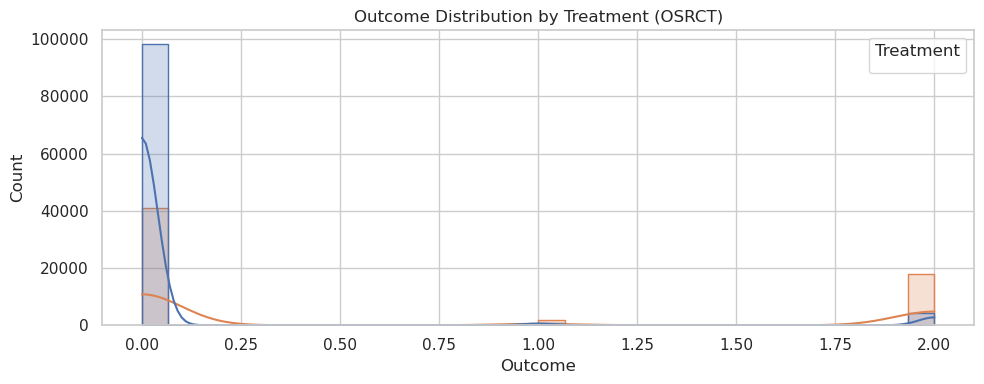

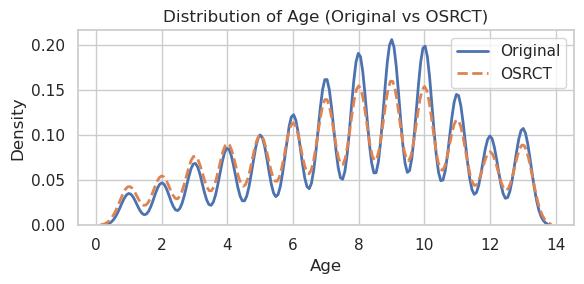

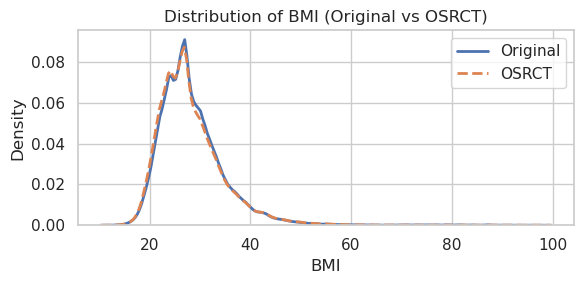

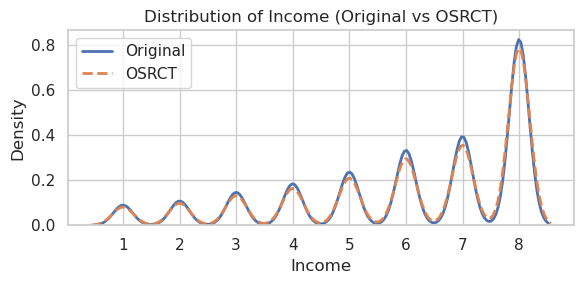

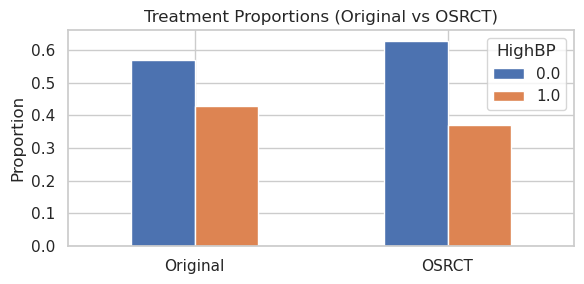

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def load_diabetes_data(file_path):
    df = pd.read_csv(file_path)
    print(f"\n✅ Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
    
    expected_columns = ['Diabetes_012', 'HighBP', 'BMI', 'Age', 'Income']
    for col in expected_columns:
        if col not in df.columns:
            raise ValueError(f"Missing expected column: {col}")
    
    print(f"\n🔍 Outcome distribution:\n{df['Diabetes_012'].value_counts(normalize=True)}")
    print(f"\n🔍 Treatment distribution:\n{df['HighBP'].value_counts(normalize=True)}")
    return df

def create_osrct_dataset(df, outcome, treatment, covariates, biasing_covariates,
                         alpha=2.0, seed=42, verbose=True, custom_model=None):
    rng = np.random.default_rng(seed)

    # Input checks
    if not set(df[treatment].unique()).issubset({0, 1}):
        raise ValueError("Treatment must be binary (0 or 1).")

    for col in biasing_covariates:
        if df[col].isnull().any():
            raise ValueError(f"Missing values in biasing covariate: {col}")
        if df[col].nunique() <= 1:
            raise ValueError(f"Low variance in biasing covariate: {col}")

    # Fit model f(Cb) = P(T=1 | Cb)
    model = custom_model or LogisticRegression()
    model.fit(df[biasing_covariates], df[treatment])

    if hasattr(model, 'decision_function'):
        logits = model.decision_function(df[biasing_covariates])
    else:
        probs_raw = model.predict_proba(df[biasing_covariates])[:, 1]
        probs_raw = np.clip(probs_raw, 1e-10, 1 - 1e-10)
        logits = np.log(probs_raw / (1 - probs_raw))

    probs = 1 / (1 + np.exp(-alpha * logits))
    sampled_treatment = rng.binomial(1, probs)
    mask = sampled_treatment == df[treatment]

    osrct_df = df[mask].copy()
    complement_df = df[~mask].copy()

    # Estimate true treatment effect (ATE) in original data
    true_effect = df[df[treatment] == 1][outcome].mean() - df[df[treatment] == 0][outcome].mean()

    if verbose:
        print(f"\n📊 True ATE (RCT): {true_effect:.4f}")
        print(f"\n📉 Sample size retained in OSRCT: {len(osrct_df)} ({len(osrct_df)/len(df):.1%})")
        print(f"📉 Sample size in complementary data: {len(complement_df)} ({len(complement_df)/len(df):.1%})")
        print(f"\n⚖️  Treatment rate in original data: {df[treatment].mean():.3f}")
        print(f"⚖️  Treatment rate in OSRCT data: {osrct_df[treatment].mean():.3f}")

    return osrct_df, true_effect, complement_df

def estimate_naive_ate(df, outcome, treatment):
    ate = df[df[treatment] == 1][outcome].mean() - df[df[treatment] == 0][outcome].mean()
    return ate

def visualize_distributions(df, osrct_df, outcome, treatment, biasing_covariates):
    print("\n📈 Plotting outcome distribution by treatment...")
    sns.set(style="whitegrid")

    # Plot 1: Distribution of outcome by treatment group
    plt.figure(figsize=(10, 4))
    sns.histplot(data=osrct_df, x=outcome, hue=treatment, kde=True, bins=30, element="step")
    plt.title("Outcome Distribution by Treatment (OSRCT)")
    plt.xlabel("Outcome")
    plt.ylabel("Count")
    plt.legend(title="Treatment")
    plt.tight_layout()
    plt.show()

    # Plot 2: Distribution of biasing covariates
    for cov in biasing_covariates:
        plt.figure(figsize=(6, 3))
        sns.kdeplot(df[cov], label="Original", linewidth=2)
        sns.kdeplot(osrct_df[cov], label="OSRCT", linestyle="--", linewidth=2)
        plt.title(f"Distribution of {cov} (Original vs OSRCT)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plot 3: Treatment imbalance comparison
    treatment_counts = pd.DataFrame({
        "Original": df[treatment].value_counts(normalize=True),
        "OSRCT": osrct_df[treatment].value_counts(normalize=True)
    }).T
    treatment_counts.plot(kind="bar", figsize=(6, 3), rot=0)
    plt.title("Treatment Proportions (Original vs OSRCT)")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

# === Main Execution ===
if __name__ == "__main__":
    FILE_PATH = filePath  # Change to your local path

    # Load and prepare
    df = load_diabetes_data(FILE_PATH)
    outcome = 'Diabetes_012'
    treatment = 'HighBP'
    biasing_covariates = ['Age', 'BMI', 'Income']
    covariates = [col for col in df.columns if col not in [outcome, treatment]]

    # Create OSRCT dataset
    osrct_df, true_effect, complement_df = create_osrct_dataset(
        df=df,
        outcome=outcome,
        treatment=treatment,
        covariates=covariates,
        biasing_covariates=biasing_covariates,
        alpha=2.0,
        seed=42,
        verbose=True
    )

    # Estimate naive ATE
    naive_ate = estimate_naive_ate(osrct_df, outcome, treatment)
    print(f"\n🧪 Naive ATE from OSRCT (biased): {naive_ate:.4f}")
    print(f"✅ True ATE from RCT: {true_effect:.4f}")
    print(f"📉 Absolute bias: {abs(naive_ate - true_effect):.4f}")

    # Plot results
    visualize_distributions(df, osrct_df, outcome, treatment, biasing_covariates)
